12
{0: [(0, 4), (0, 5)], 2: [(1, 2)], 6: [(6, 8)], 7: [(2, 7), (7, 9)], 8: [(3, 8)], 9: [(6, 9)]}


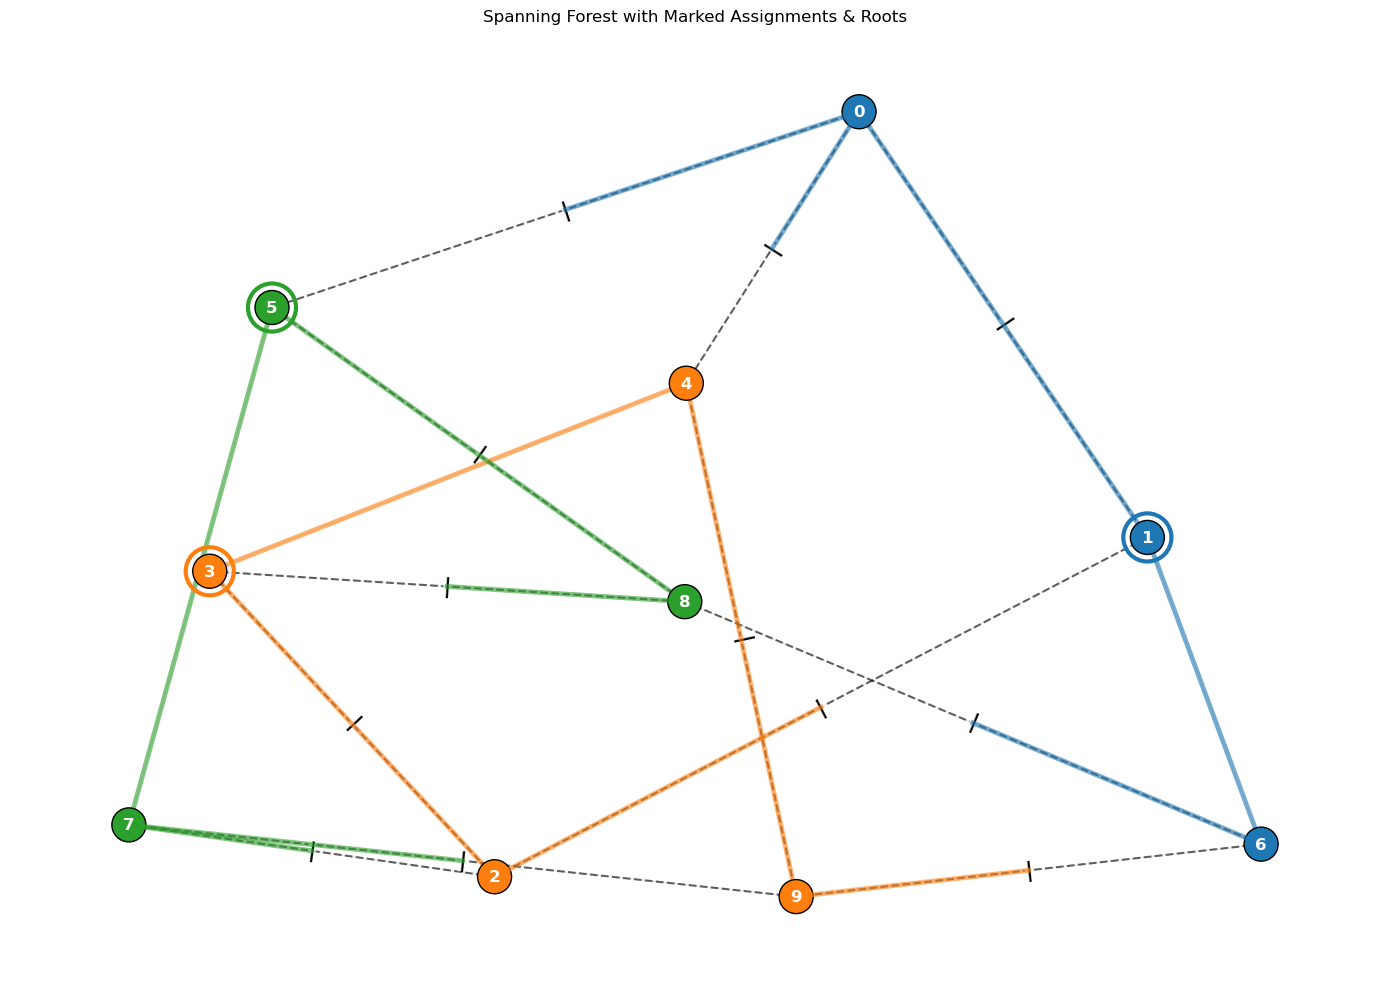

In [9]:
import networkx as nx
import stim

from spidercat.spanning_tree import *

# grf = nx.complete_graph(4)
grf = nx.petersen_graph()
# grf = nx.from_edgelist([[0, 17], [0, 1], [0, 11], [1, 2], [1, 8], [2, 3], [2, 17], [3, 4], [3, 16], [4, 5], [4, 15], [5, 6], [5, 10], [6, 7], [6, 13], [7, 8], [7, 14], [8, 9], [9, 10], [9, 12], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17]])
pos = nx.kamada_kawai_layout(grf)
from spidercat.markings import GraphMarker

N = 12
T = 4
mrkr = GraphMarker(grf, max_marks=N)
M = mrkr.find_solution(T=T)
print(sum(M.values()))

forest = build_trivial_spanning_forest(grf, M)
matchings = match_forest_leaves_to_marked_edges(forest, M)
roots = find_min_height_roots(forest)
# draw_spanning_forest_solution(grf, forest, M, matchings, roots)

spacing_tree = forest
spacing_tree = build_min_diameter_spanning_tree(grf, forest, M, max_num_trees=3, balance_factor=0.5)
matchings = match_forest_leaves_to_marked_edges(spacing_tree, M)
print(matchings)
roots = find_min_height_roots(spacing_tree)
draw_spanning_forest_solution(grf, spacing_tree, M, matchings, roots)

M: {(0, 1): 1, (0, 4): 1, (0, 5): 1, (1, 2): 1, (1, 6): 0, (2, 3): 1, (2, 7): 1, (3, 4): 0, (3, 8): 1, (4, 9): 1, (5, 7): 0, (5, 8): 1, (6, 8): 1, (6, 9): 1, (7, 9): 1}
matchings: {0: [(0, 4), (0, 5)], 2: [(1, 2)], 6: [(6, 8)], 7: [(2, 7), (7, 9)], 8: [(3, 8)], 9: [(6, 9)]}
=== Starting Clean Extraction ===
  Estimated Data Qubits: 12
  Flags start at: 12
Init Root 1 (Tree 0) -> Q0
    Link (1, 2) (1st visit): Created Flag 12, CNOT 0->12
  Node 1 -> Branch 6 (New Q1)
    Match Allocation: Node 6 absorbs (6, 8)
    Link (6, 9) (1st visit): Created Flag 13, CNOT 1->13
    Link (6, 8) (1st visit): Created Flag 14, CNOT 1->14
  Node 1 -> Primary 0 (Inherits Q0)
    Internal Mark (0, 1): Added Q2
    Match Allocation: Node 0 absorbs (0, 4)
    Match Allocation: Node 0 (Secondary Match) spawns Q3 for (0, 5)
    Link (0, 5) (1st visit): Created Flag 15, CNOT 3->15
    Link (0, 4) (1st visit): Created Flag 16, CNOT 0->16
Init Root 3 (Tree 2) -> Q4
    Link (3, 8) (1st visit): Created Flag 17, 

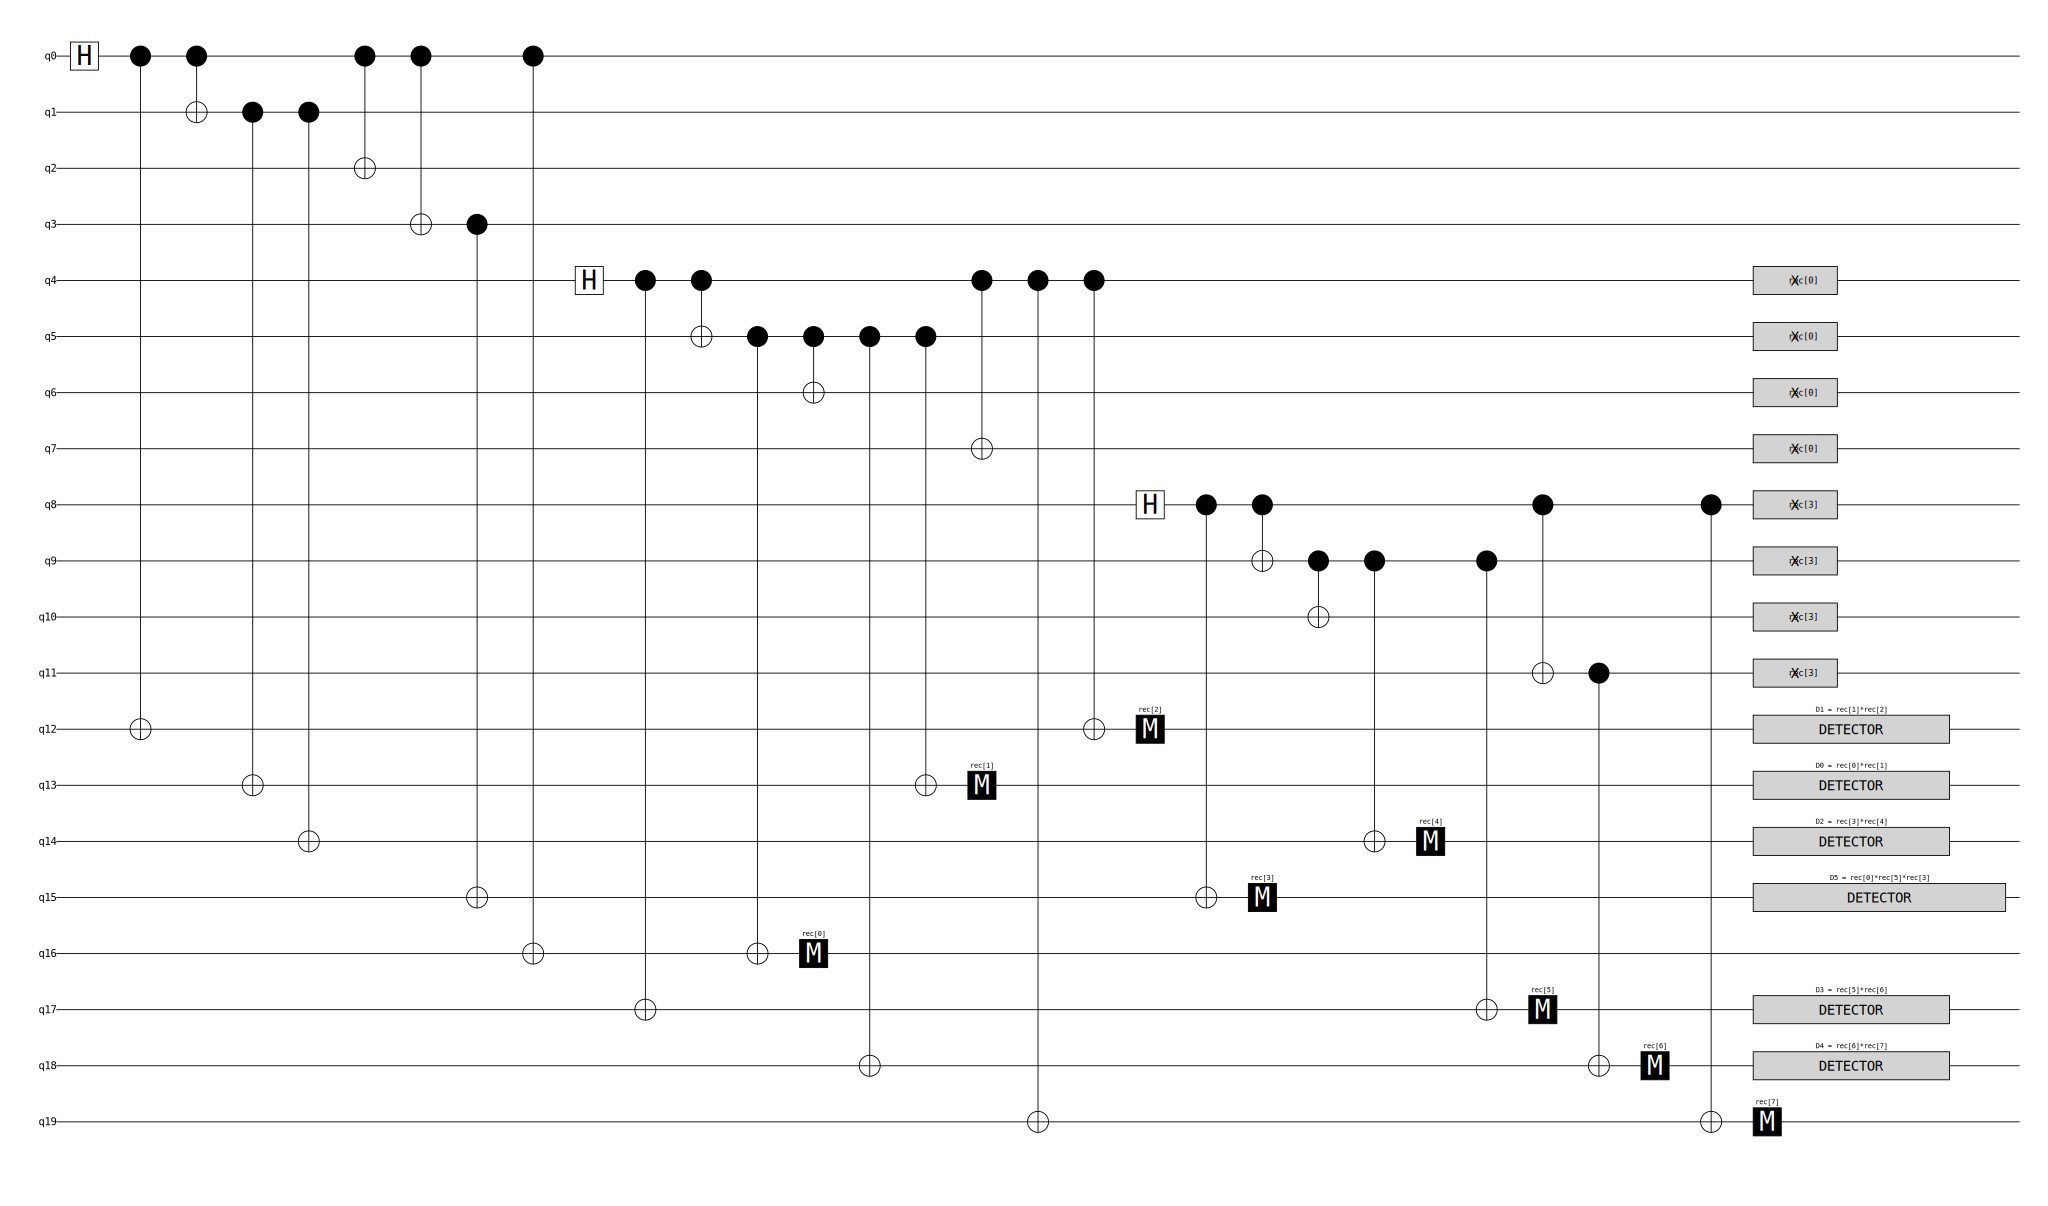

In [10]:
from spidercat.circuit_extraction import extract_circuit_rooted, make_stim_circ_noisy

M = {ed(*k): v for k, v in M.items()}
print("M:", M)
print("matchings:", matchings)
circ = extract_circuit_rooted(grf, spacing_tree, roots, M, matchings, verbose=True)
print(circ)
circ.diagram('timeline-svg')

In [3]:
from spidercat.circuit_extraction import make_stim_circ_noisy

# noisy_circ = make_stim_circ_noisy(circ, p_init=0.01, p_meas=0.01)

circ.append("M", range(sum(M.values())))
sampler = circ.compile_sampler()
samples = sampler.sample(100)
print(samples[:5])
converter = circ.compile_m2d_converter()
detectors = converter.convert(measurements=samples, append_observables=False)
error_detected = np.any(detectors, axis=1)
print(detectors[:5])
print(error_detected[:5])

[[ True  True  True  True False False False False False False]
 [False False False False  True  True  True  True  True  True]
 [False False False False  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [False False False False  True  True  True  True  True  True]]
[[False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]]
[False False False False False]


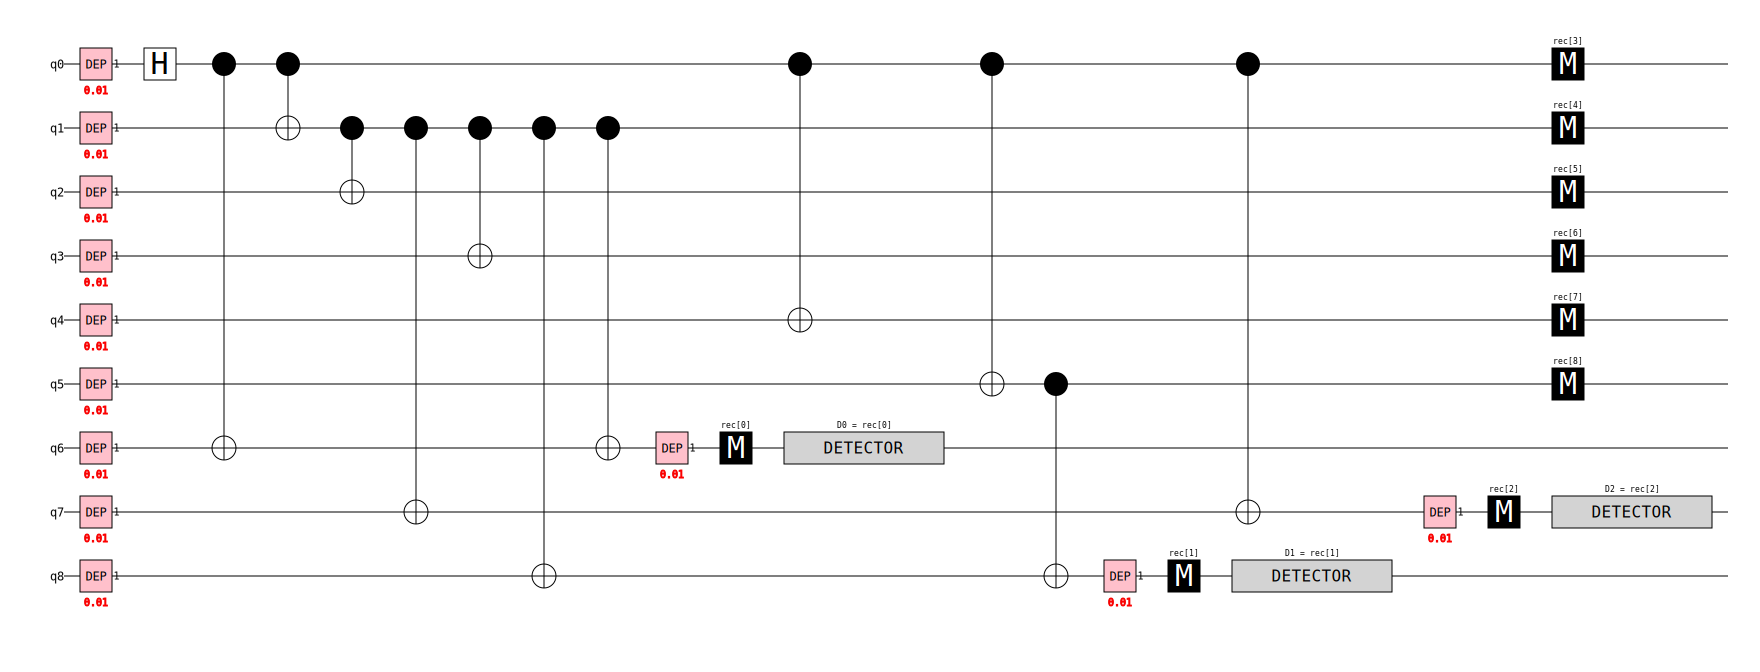

In [4]:
noisy_circ.diagram('timeline-svg')

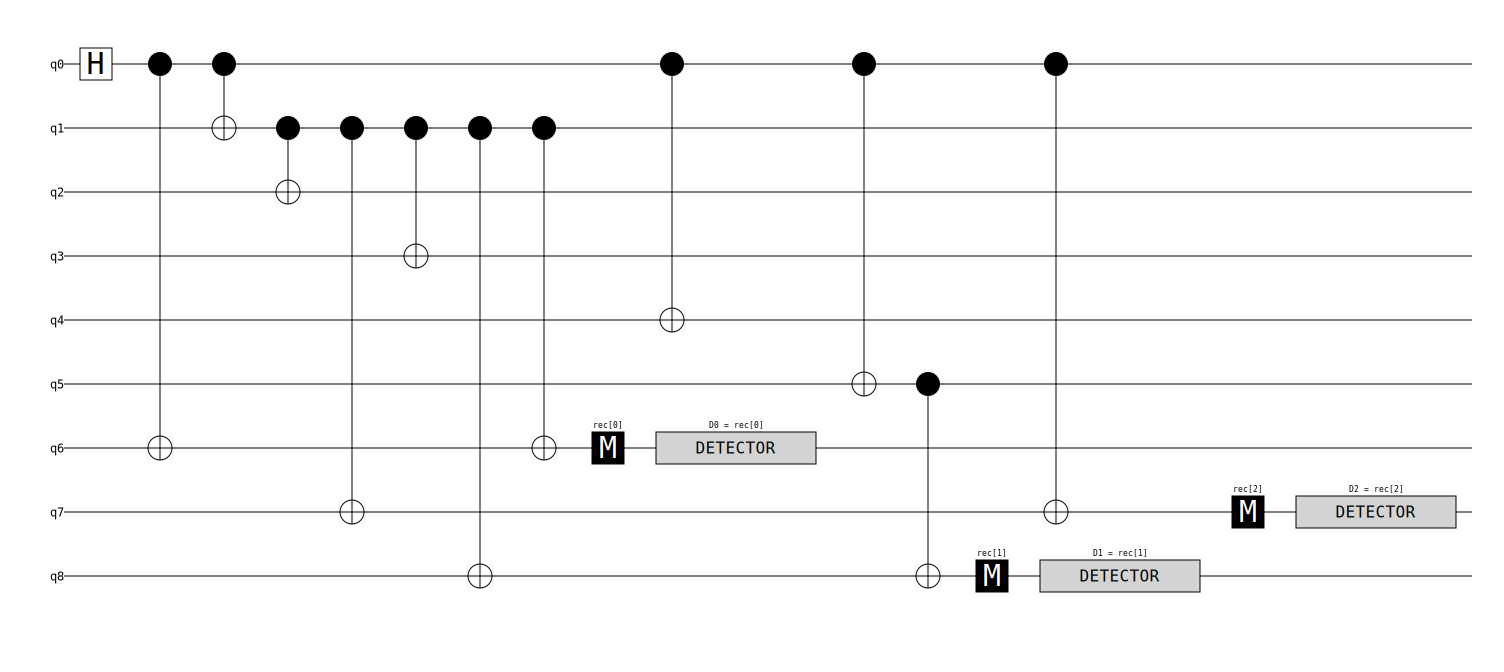

In [5]:
circ.diagram('timeline-svg')

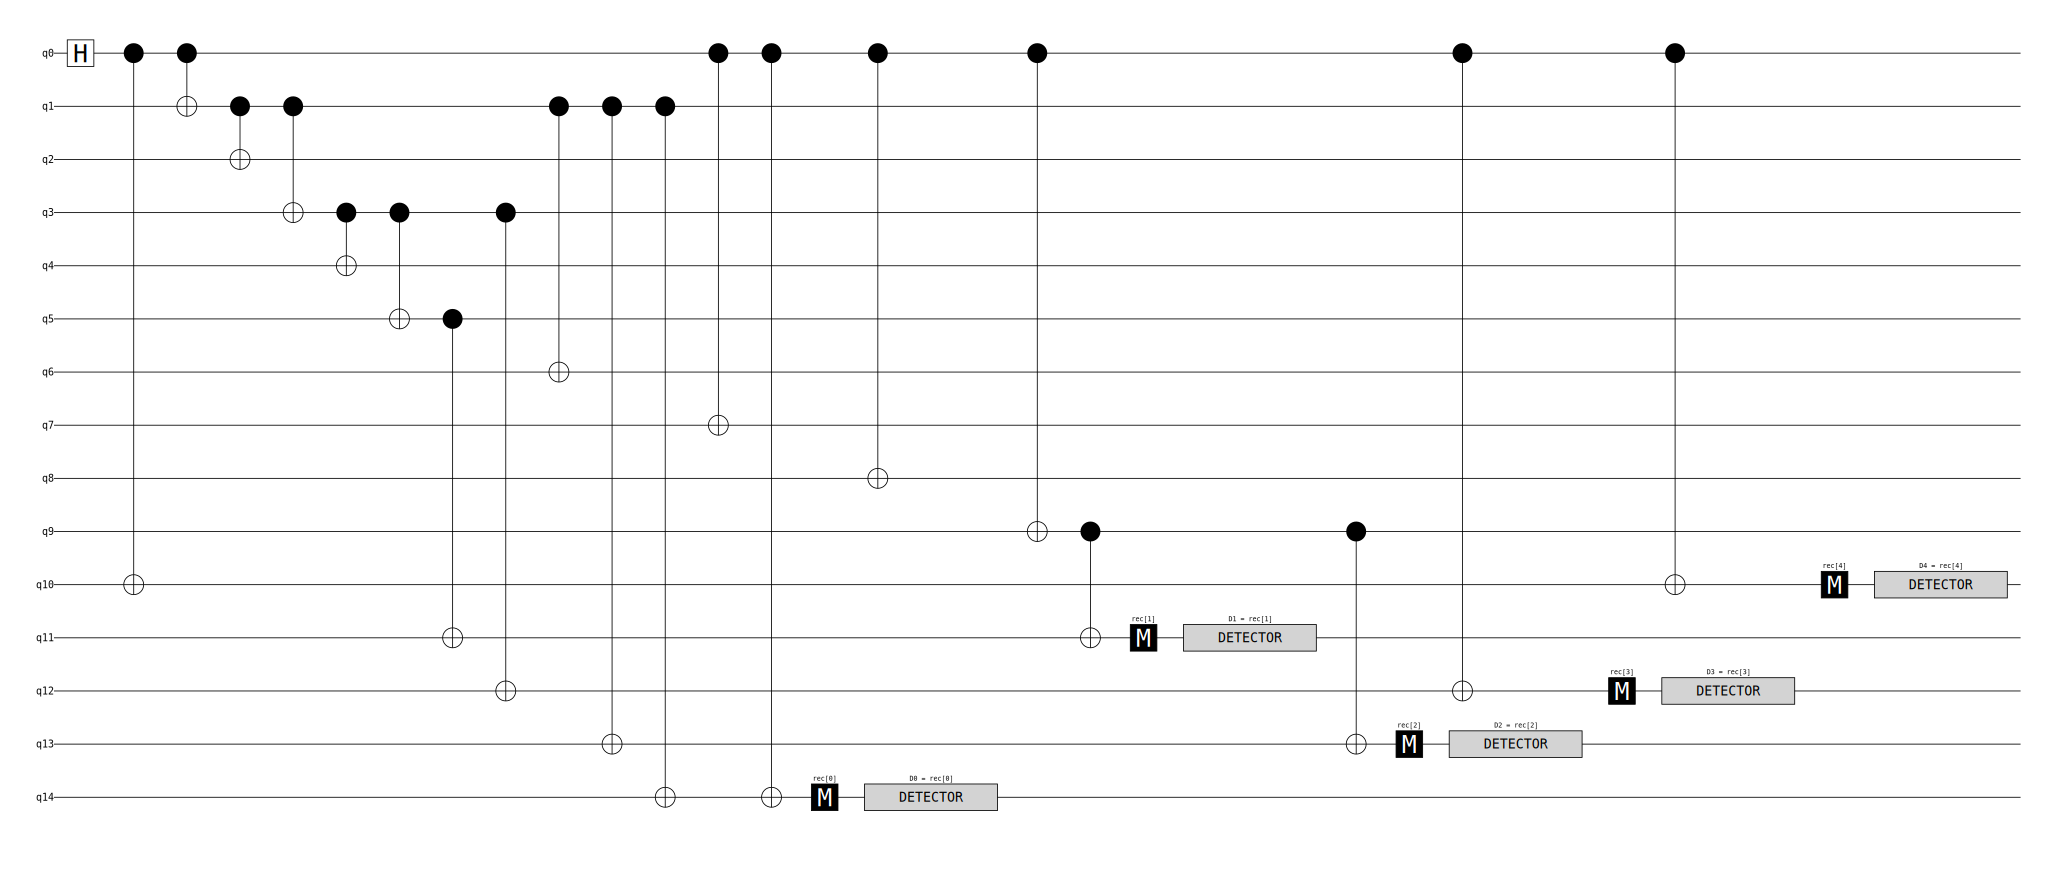

In [6]:
circ = stim.Circuit("""
H 0
CX 0 10 0 1 1 2 1 3 3 4 3 5 5 11 3 12 1 6 1 13 1 14 0 7 0 14
M 14
DETECTOR rec[-1]
CX 0 8 0 9 9 11
M 11
DETECTOR rec[-1]
CX 9 13
M 13
DETECTOR rec[-1]
CX 0 12
M 12
DETECTOR rec[-1]
CX 0 10
M 10
DETECTOR rec[-1]
""")
circ.diagram('timeline-svg')

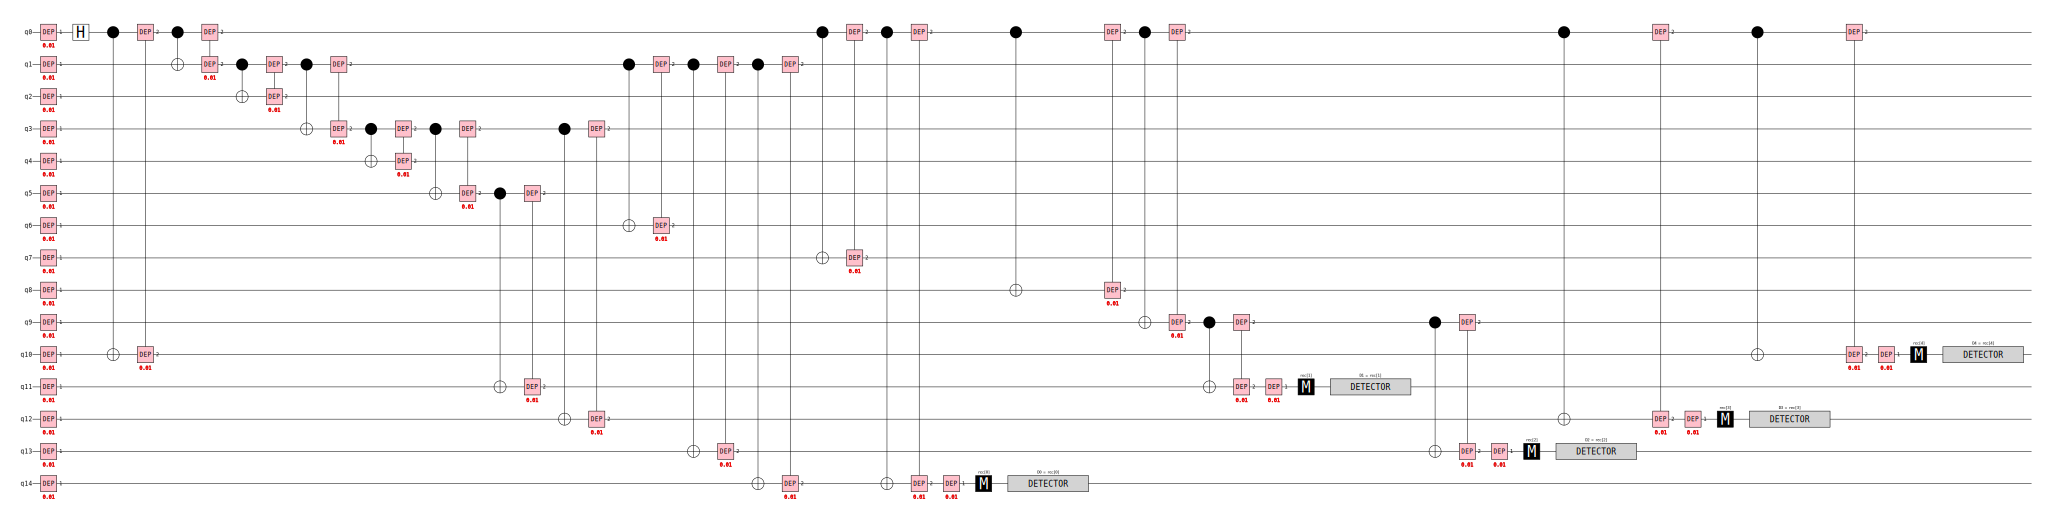

In [9]:
noisy_circ = make_stim_circ_noisy(circ, p_init=0.01, p_meas=0.01, p_2=0.01)
noisy_circ.diagram('timeline-svg')